# Example preprocessing of an IFS cube

> Author: *Valentin Christiaens*  
> Last update: *2022/04/26*

### Table of contents

* [1. Loading and visualizing the data](#1.-Loading-and-visualizing-the-data)

* [2. Preprocessing](#2.-Preprocessing)
    - [2.1. Bad pixel correction](#2.1.-Bad-pixel-correction)
    - [2.2. Bad frame removal](#2.2.-Bad-frame-removal)

The purpose of this tutorial is to show how to further improve the quality of IFS data cubes provided in the phase 2 of the Exoplanet Data Challenge (as is from each instrument's official pipeline), before applying your favourite post-processing algorithms to detect the injected planets. 

Specifically, we show how to use the relevant functions of the `VIP` package in order to correct for remaining bad pixels and remove bad frames in the second SPHERE/IFS datacube used in the data challenge.

-----------

Let's first import the packages needed in this tutorial:

In [1]:
from hciplot import plot_frames, plot_cubes
from matplotlib import pyplot as plt
import numpy as np
import os
from os.path import isdir, isfile
import requests

from vip_hci.fits import open_fits, write_fits
from vip_hci.preproc import (cube_detect_badfr_correlation, cube_fix_badpix_annuli, cube_fix_badpix_ifs, 
                             cube_fix_badpix_clump, cube_fix_badpix_with_kernel)
from vip_hci.var import mask_circle

## 1. Loading and visualizing the data

In the 'dataset' folder of the `phase2` repository you can find a toy SPHERE/IFS coronagraphic cube acquired in pupil-stabilized mode on the source HIP39826 (a star with no reported directly imaged companion). The folder also contains the associated non-coronagraphic point spread function (PSF), wavelength vector and parallactic angles (the latter also including information on the airmass of the source).

Let's now load the data. Note that more info on opening and visualizing fits files with VIP in general is available [in the first VIP tutorial](https://vip.readthedocs.io/en/latest/tutorials/01_quickstart.html).

**Replace next box when zenodo link available**

In [2]:
test_set = 'sphere0'

datpath = '../../../Documents/eidc2_data/{}/'.format(test_set)
if not isdir(datpath):
    os.makedirs(datpath)

In [3]:
if not isfile(datpath+'parallactic_angles_{}.fits'.format(test_set)):
    zeno_url = 'https://zenodo.org/record/6477664/files/'
    cube_url = 'image_cube_sphere0.fits?download=1'
    psf_url = 'psf_cube_sphere0.fits?download=1'
    lbda_url = 'wavelength_vect_sphere0.fits?download=1'
    pa_url = 'parallactic_angles_sphere0.fits?download=1'

    r_cube = requests.get(zeno_url+cube_url)
    r_psf = requests.get(zeno_url+psf_url)
    r_lbda = requests.get(zeno_url+lbda_url)
    r_pa = requests.get(zeno_url+pa_url)
    
    with open(datpath+'image_cube_{}.fits'.format(test_set), 'wb') as f:
        f.write(r_cube.content)
    with open(datpath+'psf_cube_{}.fits'.format(test_set), 'wb') as f:
        f.write(r_psf.content)
    with open(datpath+'wavelength_vect_{}.fits'.format(test_set), 'wb') as f:
        f.write(r_lbda.content)
    with open(datpath+'parallactic_angles_{}.fits'.format(test_set), 'wb') as f:
        f.write(r_pa.content)

In [4]:
cubename = datpath+'image_cube_{}.fits'.format(test_set)
angname = datpath+'parallactic_angles_{}.fits'.format(test_set)
lbdaname = datpath+'wavelength_vect_{}.fits'.format(test_set)

cube, header = open_fits(cubename, header=True)
lbdas = open_fits(lbdaname)
pa = open_fits(angname)
derot_angles = pa[0]

nch, nz, ny, nx = cube.shape

Fits HDU-0 data and header successfully loaded. Data shape: (39, 65, 189, 189)
Fits HDU-0 data successfully loaded. Data shape: (39,)
Fits HDU-0 data successfully loaded. Data shape: (2, 65)


Each IFS spectral cube consists of 39 monochromatic images spread in wavelengths between the Y and J bands ('YJ' mode) or Y and H bands ('YJH' mode). Here the IFS+ADI cube contains 65 such spectral cubes combined into a single master cube. The first column of the parallactic angle file actually contains the parallactic (derotation) angles, while the second columns contains the airmass at which each spectral cube was obtained.

The **master spectral cube** is already centered. Let's inspect the first and last wavelengths, using `hciplot.plot_cubes` (feel free to set the backend to 'bokeh' to read pixel values interactively):

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time,lambda]   (flux)
:Cube_shape	[189, 189, 65, 39]


:DynamicMap   [time,lambda]
   :Image   [x,y]   (flux)
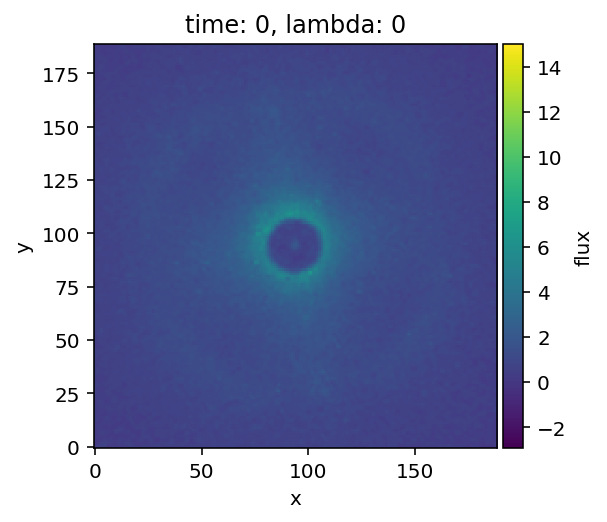

In [5]:
plot_cubes(cube, vmax=15)#, backend='bokeh')

Inspection of the master cube shows the presence of residual bad pixels (e.g. at time 30 of lambda 0), and the presence of frames very different from the others (specifically for time > 60).

In the next section, we will show how to better prepare the master cube by correcting bad pixels and trimming bad frames, in order to increase the performance of typical post-processing algorithms.

[Go to the top](#Table-of-contents)

## 2. Preprocessing

### 2.1. Bad pixel correction

Let's identify bad pixels using the dedicated function in `VIP` for IFS cubes. In brief, the algorithm leverages on the radial expansion of the PSF with wavelength to subtract an estimate of the stellar PSF at each wavelength based on the median of rescaled frames at other wavelengths. These residual images are then used to identify high-spatial frequency outlier signals, i.e. $>$`sigma_clip` sigma discrepant from neighbour pixel intensities (where the relevant spatial scale is considered through the `fwhm` parameter). The algorithm can run iteratively up to `max_nit` iterations by setting `clumps=True`.

**Warning**: the next cell is computer intensive.

In [8]:
cube_corr, bpm_mask, cube_res = cube_fix_badpix_ifs(cube, lbdas, fluxes=None, mask=None, cy=None, cx=None, 
                                                    sigma_clip=4, fwhm=5., clumps=True,
                                                    protect_mask=5, mad=True, min_thr=(-1,2), 
                                                    max_nit=5, verbose=True, full_output=True)

write_fits(datpath+"master_bad_pixel_map.fits", bpm_mask)

Fits file successfully overwritten


The default method to correct bad pixels is through the median of good neighbours. The corrected cube `cube_corr` may therefore still present some inhomogeneities after bad pixel removal. Let's instead use a Gaussian kernel interpolation for the correction:

In [10]:
bpm_mask = open_fits(datpath+"master_bad_pixel_map.fits")
cube_corr_k = np.zeros_like(cube)
for i in range(nch):
    cube_corr_k[i] = cube_fix_badpix_with_kernel(cube[i], bpm_mask=bpm_mask[i], mode='gauss', fwhm=1)

Fits HDU-0 data successfully loaded. Data shape: (39, 65, 189, 189)


Let's compare a frame before and after bad pixel correction:

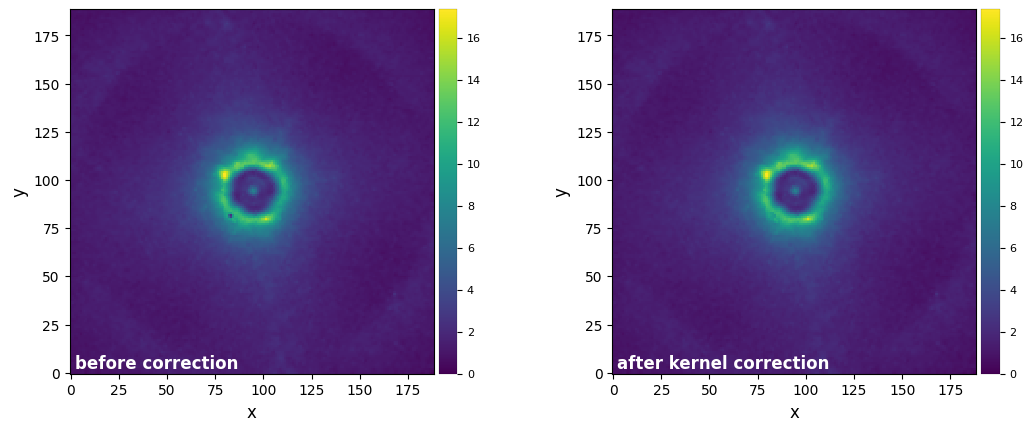

In [17]:
idx = 0
plot_frames((cube[-1,idx], #cube_corr[-1,idx], 
             cube_corr_k[-1,idx]),
            label = ('before correction', #'after median correction', 
                     'after correction'),
            vmin=0, vmax=float(np.amax(cube[-1,idx])))

Note that it may be possible to obtain better bad pixel corrections by tweaking the values of the optional parameter (e.g. `sigma_clip`, `mad`, `min_thr`) or by combining different algorithms. Other bad pixel identification/correction algorithms in `VIP` include:

- `cube_fix_badpix_isolated` which performs rapidly and efficiently for isolated bad pixels;
- `cube_fix_badpix_clump` which is slower but more effective for clumps of bad pixels;
- `cube_fix_badpix_annuli` which is relevant for the identification and correction of bad pixels in circularly symmetric PSFs.

[Go to the top](#Table-of-contents)

### 2.2. Bad frames trim

Let's now remove bad frames, based on the cross-correlation between each frame and the median of the ADI sequence (at each wavelength). We use the Structural Similarity (SSIM) index (REF), computed in an annular region beyond the coronagraphic mask. It is worth running a first pass of the algorithm using a percentile threshold, plot the values for each cube, and then  define an absolute threshold based on the mean SSIM values (over all wavelengths):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-26 12:29:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.059433
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-26 12:29:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.036783
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-26 12:29:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0

/Users/valentin/GitHub/VIP/vip_hci/preproc/badframes.py:332: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=vip_figsize)


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-26 12:29:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.038848
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-26 12:29:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0:00:00.040177
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-26 12:29:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 7 out of 65 (10.8%)
Running time:  0

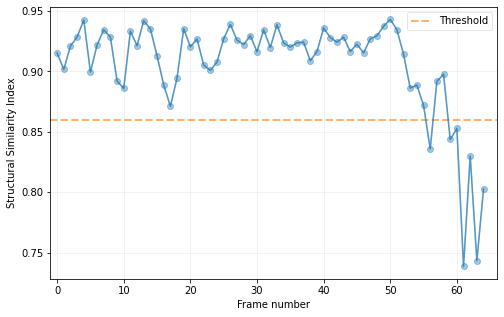

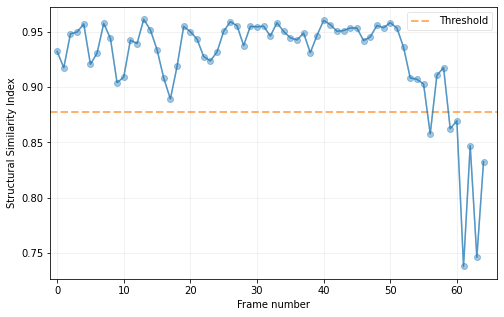

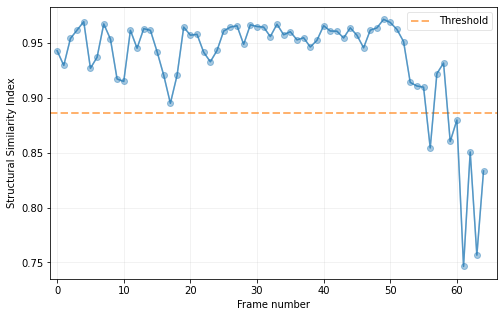

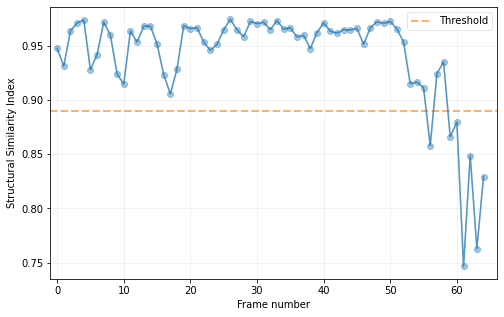

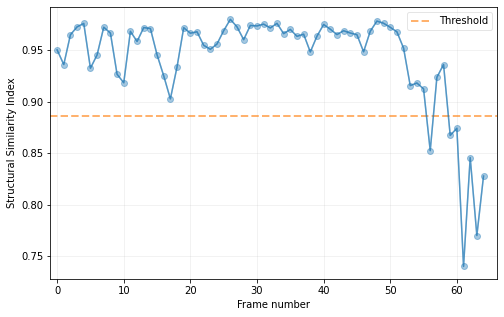

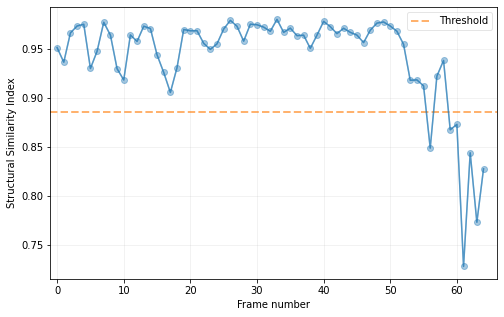

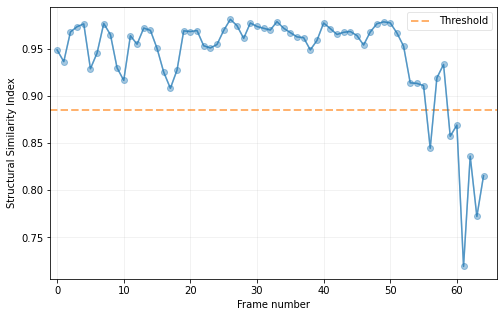

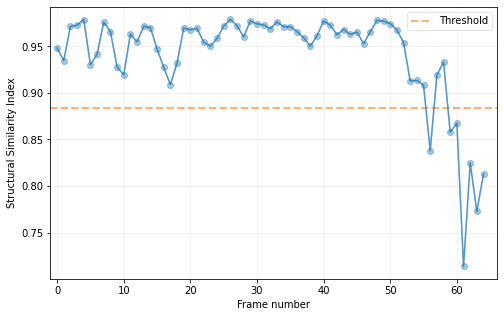

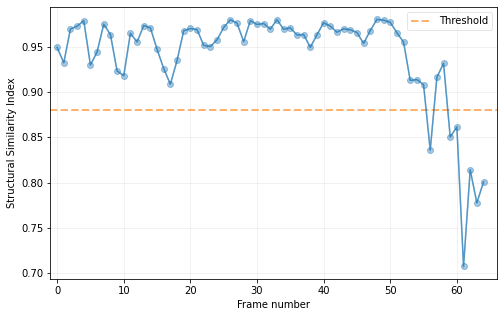

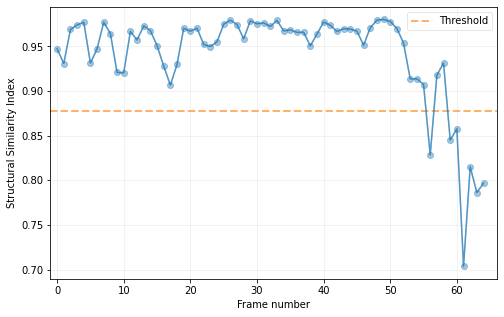

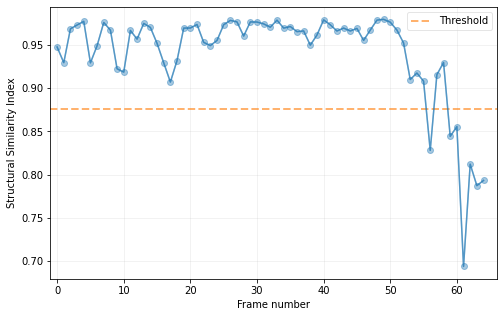

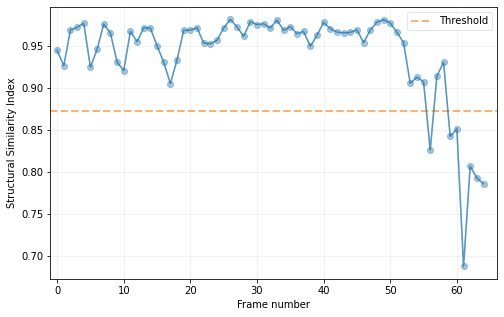

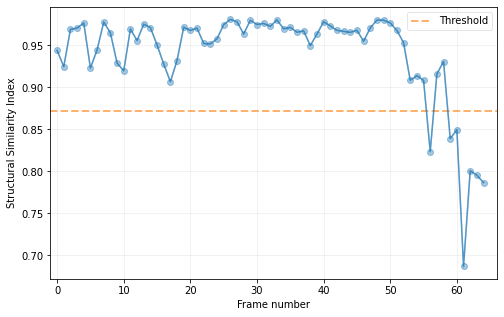

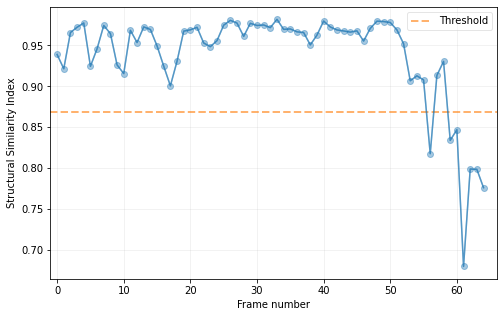

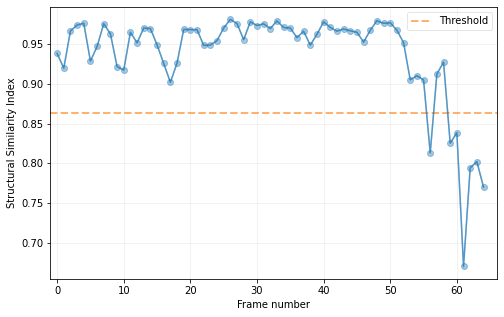

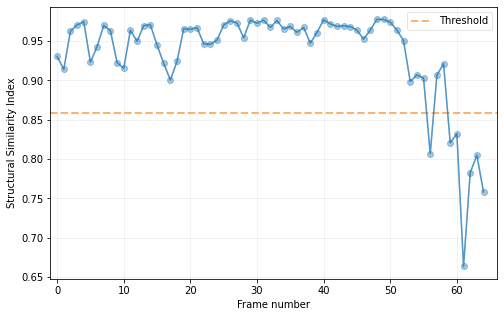

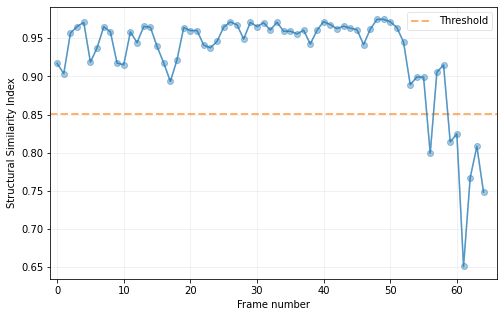

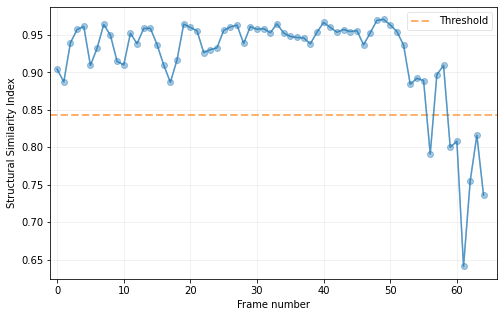

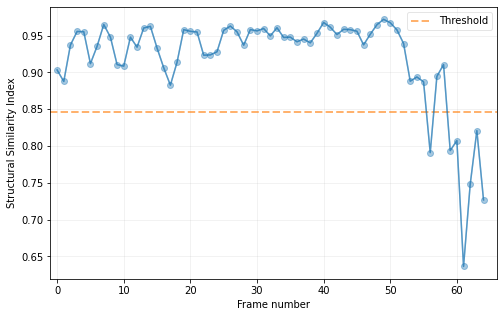

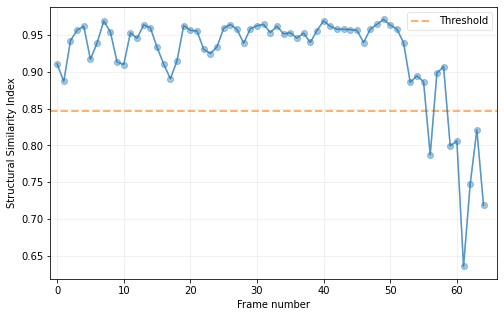

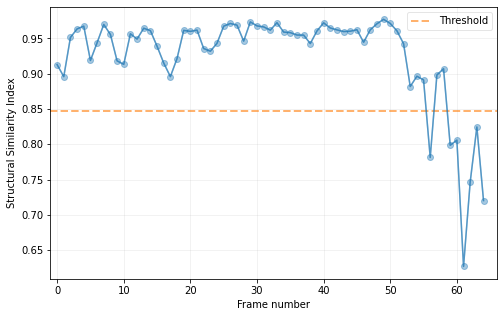

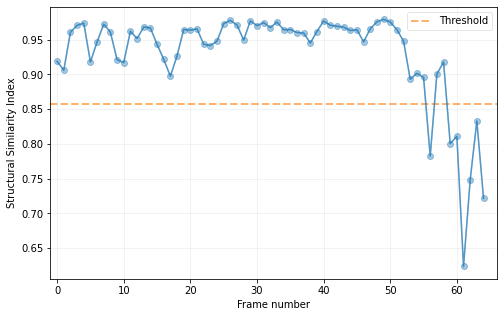

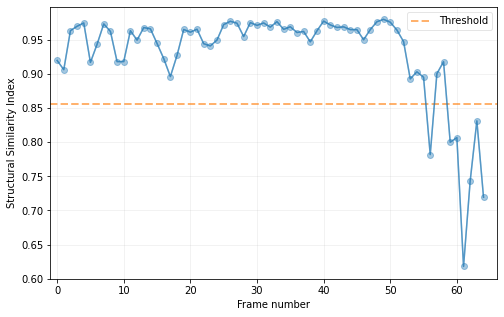

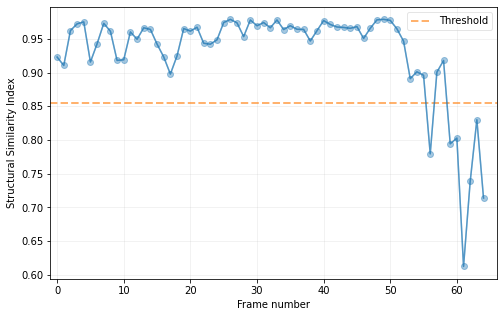

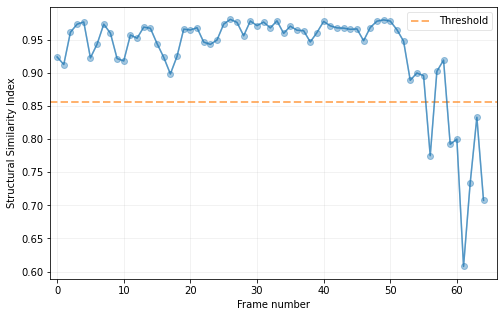

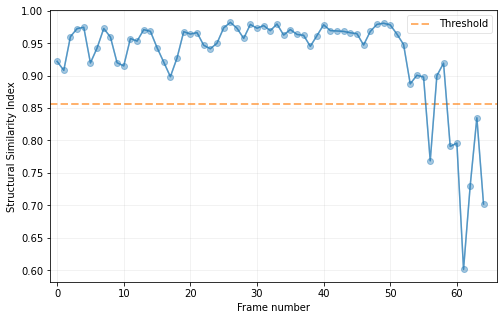

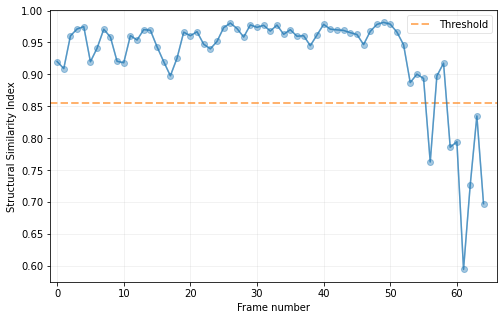

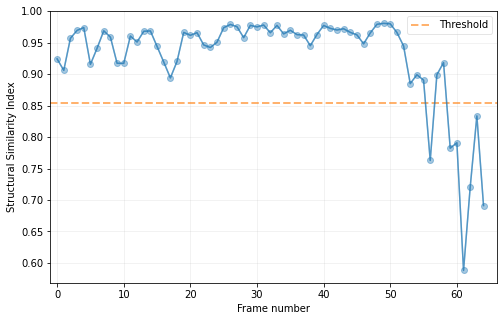

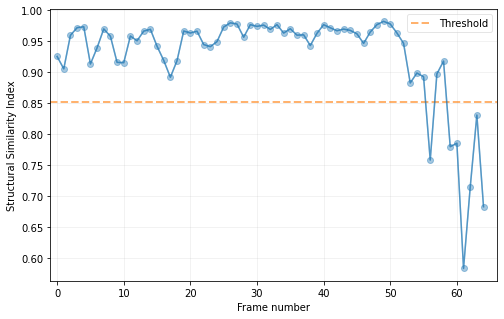

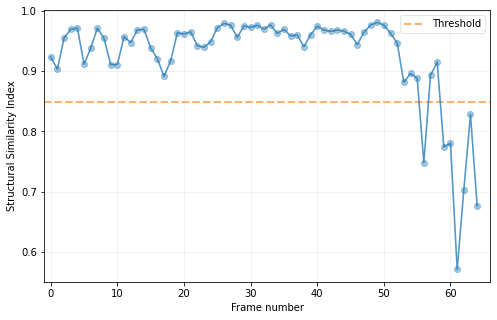

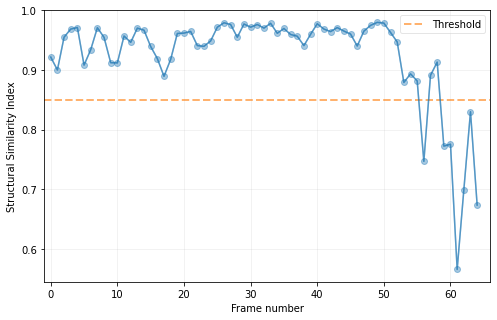

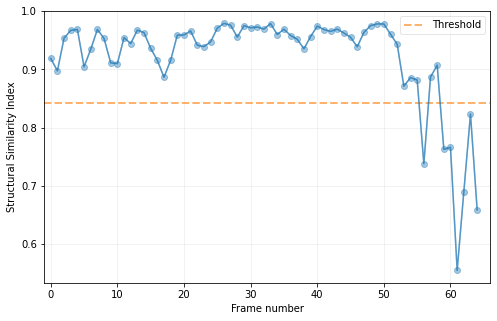

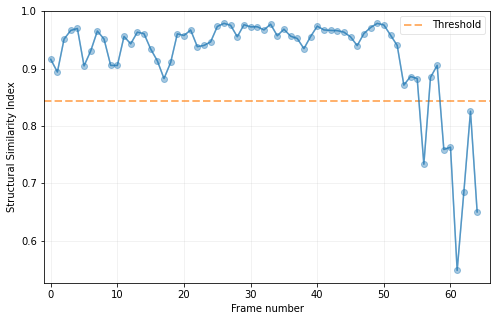

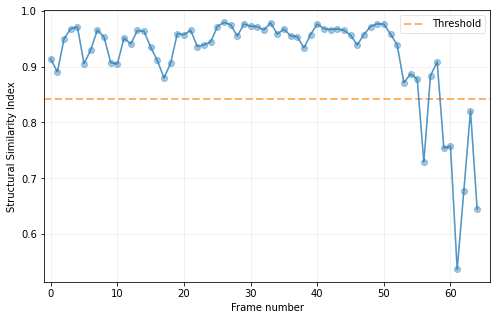

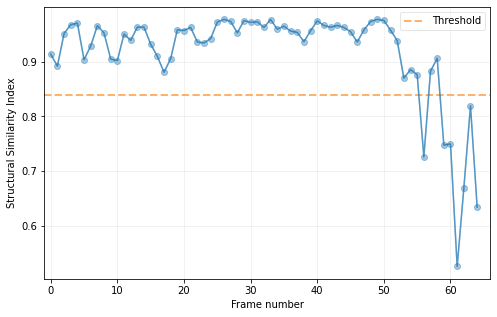

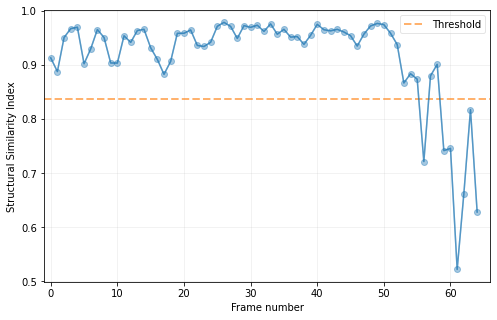

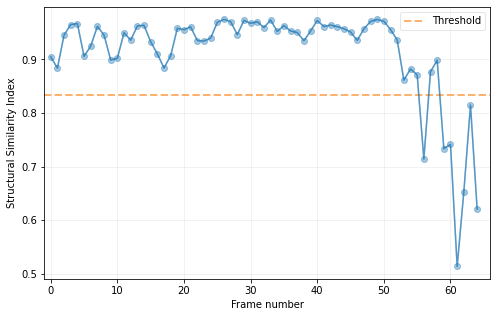

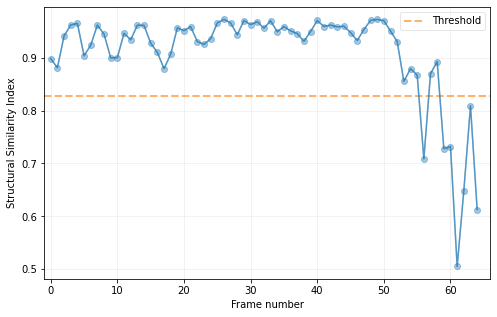

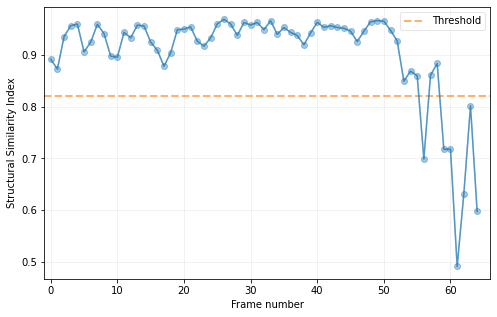

In [18]:
ssim = np.zeros([nch, nz])
for i in range(nch):
    good_idx, bad_idx, ssim[i] = cube_detect_badfr_correlation(cube_corr_k[i], 
                                                               frame_ref=np.median(cube_corr[i], axis=0), 
                                                               crop_size=61, dist='ssim', percentile=10, 
                                                               mode='annulus', inradius=8, width=18, 
                                                               plot=True, verbose=True, full_output=True)

Note that other distances can be used, such as the Pearson correlation coefficient. 

Although a plot was made for the ADI cube at each wavelength, let's visualize this better by plotting the measured SSIM values for a few different wavelengths, and the average over all channels:

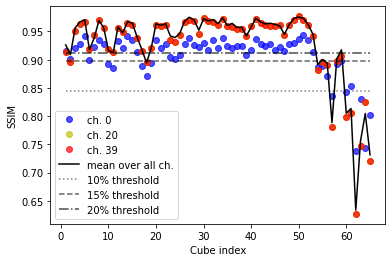

In [19]:
plt.plot(range(1,nz+1), ssim[0], 'bo', label='ch. 0', alpha=0.7)
plt.plot(range(1,nz+1), ssim[20], 'yo', label='ch. 20', alpha=0.7)
plt.plot(range(1,nz+1), ssim[20], 'ro', label='ch. 39', alpha=0.7)
plt.plot(range(1,nz+1), np.mean(ssim,axis=0), 'k', label='mean over all ch.')
plt.plot(range(1,nz+1), [np.percentile(np.mean(ssim,axis=0),10)]*nz, 'k:', alpha=0.5, label='10% threshold')
plt.plot(range(1,nz+1), [np.percentile(np.mean(ssim,axis=0),15)]*nz, 'k--', alpha=0.6, label='15% threshold')
plt.plot(range(1,nz+1), [np.percentile(np.mean(ssim,axis=0),20)]*nz, 'k-.', alpha=0.7, label='20% threshold')
plt.xlabel(r"Cube index")
plt.ylabel(r"SSIM")
plt.legend()

Overall the trends are very similar at all wavelengths: the end of the sequence suffered from much worse conditions, as the dropping SSIM values testify. 

You can finally set a threshold in terms of percentile to remove bad frames depending on your post-processing algorithm (how sensitive it is to very different PSFs) and the regime in which the candidate you are looking after is located (speckle-dominated vs photon noise dominated).

Here, let's consider for example removing the 15% worst frames. The mean appears to follow closely the last channel, so we'll just get the good indices from the last spectral channel:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-04-26 12:29:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 10 out of 65 (15.4%)
Running time:  0:00:00.043775
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


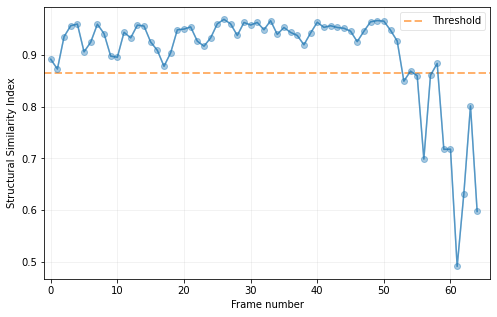

In [20]:
perc_thr = 15
good_idx, bad_idx = cube_detect_badfr_correlation(cube_corr_k[-1], frame_ref=np.median(cube_corr[-1], axis=0), 
                                                  crop_size=61, dist='ssim', percentile=perc_thr, 
                                                  mode='annulus', inradius=8, width=18, 
                                                  plot=True, verbose=True, full_output=False)

Finally, let's save the master cube and associated parallactic angles after bad frame trim:

In [21]:
write_fits(datpath+'image_cube_sphere2_ready.fits', cube_corr_k[:,good_idx])
write_fits(datpath+'parallactic_angles_sphere2_ready.fits', pa[:,good_idx])

Fits file successfully overwritten
Fits file successfully overwritten


[Go to the top](#Table-of-contents)